# 3DUNet Model for Tumor Segmentation in MR Brain Images
Hamidreza Rashidy Kanan  
2022

## 1. Import Required Libraries

In [1]:
import keras
import json
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K 

import util
from public_tests import *
from test_utils import *

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Using TensorFlow backend.


## 1. Dataset

### 1.2 MRI Data Processing

We often encounter MR images in the [DICOM format](https://en.wikipedia.org/wiki/DICOM). 
- The DICMO format is the output format for most commercial MRI scanners. This type of data can be processed using the [pydicom](https://pydicom.github.io/pydicom/stable/getting_started.html) Python library. 

In this project, we will be using the data from the [Decathlon 10 Challenge](https://decathlon-10.grand-challenge.org). This data has been mostly pre-processed for the competition participants, however in real practice, MRI data needs to be significantly pre-preprocessed before we can use it to train our models.

<a name="1-3"></a>
### 1.3 Exploring the Dataset

Our dataset is stored in the [NifTI-1 format](https://nifti.nimh.nih.gov/nifti-1/) and we will be using the [NiBabel library](https://github.com/nipy/nibabel) to interact with the files. Each training sample is composed of two separate files:

The first file is an image file containing a 4D array of MR image in the shape of (240, 240, 155, 4). 
-  The first 3 dimensions are the X, Y, and Z values for each point in the 3D volume, which is commonly called a voxel. 
- The 4th dimension is the values for 4 different sequences
    - 0: FLAIR: "Fluid Attenuated Inversion Recovery" (FLAIR)
    - 1: T1w: "T1-weighted"
    - 2: t1gd: "T1-weighted with gadolinium contrast enhancement" (T1-Gd)
    - 3: T2w: "T2-weighted"

The second file in each training example is a label file containing a 3D array with the shape of (240, 240, 155).  
- The integer values in this array indicate the "label" for each voxel in the corresponding image files:
    - 0: background
    - 1: edema
    - 2: non-enhancing tumor
    - 3: enhancing tumor

We have access to a total of 484 training images which we will be splitting into a training (80%) and validation (20%) dataset.

Let's begin by looking at one single case and visualizing the data! You have access to 10 different cases via this notebook and we strongly encourage you to explore the data further on your own.

We'll use the [NiBabel library](https://nipy.org/nibabel/nibabel_images.html) to load the image and label for a case. The function is shown below to give you a sense of how it works. 

In [2]:
# set home directory and data directory
HOME_DIR = "data/BraTS-Data/"
DATA_DIR = HOME_DIR

def load_case(image_nifty_file, label_nifty_file):
    # load the image and label file, get the image content and return a numpy array for each
    image = np.array(nib.load(image_nifty_file).get_fdata())
    label = np.array(nib.load(label_nifty_file).get_fdata())
    
    return image, label

We'll now visualize an example.  For this, we use a pre-defined function we have written in the `util.py` file that uses `matplotlib` to generate a summary of the image. 

The colors correspond to each class.
- Red is edema
- Green is a non-enhancing tumor
- Blue is an enhancing tumor. 

Do feel free to look at this function at your own time to understand how this is achieved.

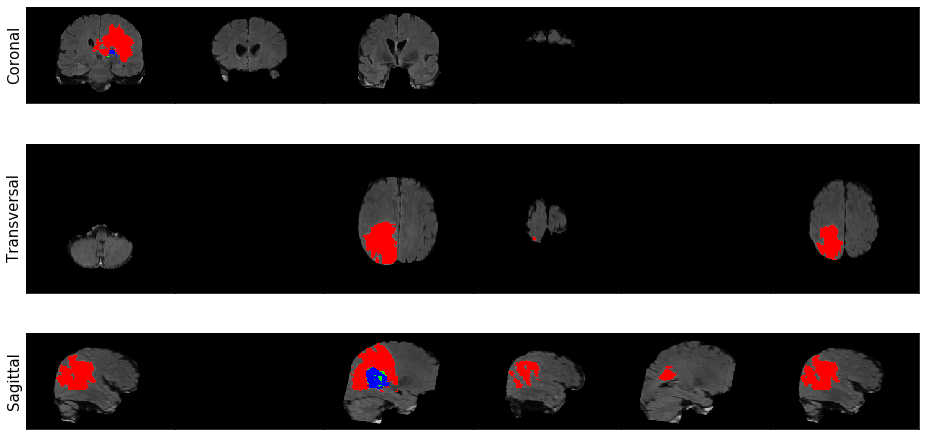

In [3]:
image, label = load_case(DATA_DIR + "imagesTr/BRATS_003.nii.gz", DATA_DIR + "labelsTr/BRATS_003.nii.gz")
image = util.get_labeled_image(image, label)

util.plot_image_grid(image)

<a name="1-4"></a>
### 1.4 Data Preprocessing using Patches

While our dataset is provided to us post-registration and in the NIfTI format, we still have to do some minor pre-processing before feeding the data to our model. 

##### Generate sub-volumes

##### Standardization (mean 0, stdev 1)

In [5]:
def get_sub_volume(image, label, 
                   orig_x = 240, orig_y = 240, orig_z = 155, 
                   output_x = 160, output_y = 160, output_z = 16,
                   num_classes = 4, max_tries = 1000, 
                   background_threshold=0.95):
    """
    Extract random sub-volume from original images.

    Args:
        image (np.array): original image, 
            of shape (orig_x, orig_y, orig_z, num_channels)
        label (np.array): original label. 
            labels coded using discrete values rather than
            a separate dimension, 
            so this is of shape (orig_x, orig_y, orig_z)
        orig_x (int): x_dim of input image
        orig_y (int): y_dim of input image
        orig_z (int): z_dim of input image
        output_x (int): desired x_dim of output
        output_y (int): desired y_dim of output
        output_z (int): desired z_dim of output
        num_classes (int): number of class labels
        max_tries (int): maximum trials to do when sampling
        background_threshold (float): limit on the fraction 
            of the sample which can be the background

    returns:
        X (np.array): sample of original image of dimension 
            (num_channels, output_x, output_y, output_z)
        y (np.array): labels which correspond to X, of dimension 
            (num_classes, output_x, output_y, output_z)
    """
    # Initialize features and labels with `None`
    X = None
    y = None

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    tries = 0
    
    while tries < max_tries:
        # randomly sample sub-volume by sampling the corner voxel
        # hint: make sure to leave enough room for the output dimensions!
        # do not remove/delete the '0's
        start_x = np.random.randint(0,orig_x-output_x+1)
        start_y = np.random.randint(0,orig_y-output_y+1)
        start_z = np.random.randint(0,orig_z-output_z+1)

        # extract relevant area of label
        y = label[start_x: start_x + output_x,
                  start_y: start_y + output_y,
                  start_z: start_z + output_z]
        
        # One-hot encode the categories.
        # This adds a 4th dimension, 'num_classes'
        # (output_x, output_y, output_z, num_classes)
        y = keras.utils.to_categorical(y, num_classes=num_classes)

        # compute the background ratio (this has been implemented for you)
        bgrd_ratio = np.sum(y[:, :, :, 0])/(output_x * output_y * output_z)

        # increment tries counter
        tries += 1

        # if background ratio is below the desired threshold,
        # use that sub-volume.
        # otherwise continue the loop and try another random sub-volume
        if bgrd_ratio < background_threshold:

            # make copy of the sub-volume
            X = np.copy(image[start_x: start_x + output_x,
                              start_y: start_y + output_y,
                              start_z: start_z + output_z, :])
            
            # change dimension of X
            # from (x_dim, y_dim, z_dim, num_channels)
            # to (num_channels, x_dim, y_dim, z_dim)
            X = np.moveaxis(X, -1, 0)

            # change dimension of y
            # from (x_dim, y_dim, z_dim, num_classes)
            # to (num_classes, x_dim, y_dim, z_dim)
            y = np.moveaxis(y, -1, 0)

            ### END CODE HERE ###
            
            # take a subset of y that excludes the background class
            # in the 'num_classes' dimension
            y = y[1:, :, :, :]
    
            return X, y

    # if we've tried max_tries number of samples
    # Give up in order to avoid looping forever.
    print(f"Tried {tries} times to find a sub-volume. Giving up...")

You can run the following cell to look at a candidate patch and ensure that the function works correctly. We'll look at the enhancing tumor part of the label.

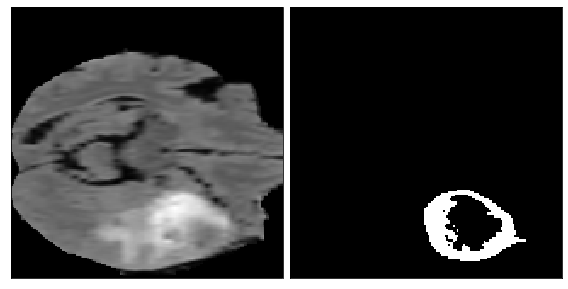

In [7]:
image, label = load_case(DATA_DIR + "imagesTr/BRATS_001.nii.gz", DATA_DIR + "labelsTr/BRATS_001.nii.gz")
X, y = get_sub_volume(image, label)
# enhancing tumor is channel 2 in the class label
# you can change indexer for y to look at different classes
util.visualize_patch(X[0, :, :, :], y[2])

In [8]:
def standardize(image):
    """
    Standardize mean and standard deviation 
        of each channel and z_dimension.

    Args:
        image (np.array): input image, 
            shape (num_channels, dim_x, dim_y, dim_z)

    Returns:
        standardized_image (np.array): standardized version of input image
    """
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # initialize to array of zeros, with same shape as the image
    standardized_image = np.zeros(image.shape)

    # iterate over channels
    for c in range(image.shape[0]):
        # iterate over the `z` dimension
        for z in range(image.shape[3]):
            # get a slice of the image 
            # at channel c and z-th dimension `z`
            image_slice = image[c,:,:,z]

            # subtract the mean from image_slice
            centered = image_slice - np.mean(image_slice)
            
            # divide by the standard deviation (only if it is different from zero)
            if np.std(centered) != 0:
                centered_scaled = centered / np.std(centered)

                # update  the slice of standardized image
                # with the scaled centered and scaled image
            standardized_image[c, :, :, z] = centered_scaled

    ### END CODE HERE ###

    return standardized_image

Let's visualize our patch again just to make sure it won't look different since the `imshow` function we used to visualize automatically normalizes the pixels when displaying in black and white.

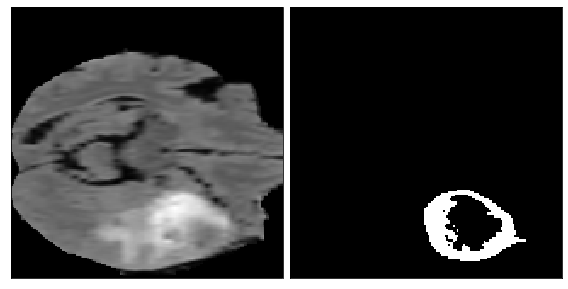

In [10]:
X_norm = standardize(X)
util.visualize_patch(X_norm[0, :, :, :], y[2])

## 2. 3D U-Net Model

<a name="3"></a>
## 3. Metrics

In [11]:
def single_class_dice_coefficient(y_true, y_pred, axis=(0, 1, 2), 
                                  epsilon=0.00001):
    """
    Compute dice coefficient for single class.

    Args:
        y_true (Tensorflow tensor): tensor of ground truth values for single class.
                                    shape: (x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): tensor of predictions for single class.
                                    shape: (x_dim, y_dim, z_dim)
        axis (tuple): spatial axes to sum over when computing numerator and
                      denominator of dice coefficient.
                      Hint: pass this as the 'axis' argument to the K.sum function.
        epsilon (float): small constant added to numerator and denominator to
                        avoid divide by 0 errors.
    Returns:
        dice_coefficient (float): computed value of dice coefficient.     
    """

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    dice_numerator = 2 *  keras.backend.sum(y_true * y_pred) + epsilon
    dice_denominator = keras.backend.sum(y_true) + keras.backend.sum(y_pred) + epsilon
    dice_coefficient = dice_numerator / dice_denominator
    
    ### END CODE HERE ###

    return dice_coefficient

In [13]:
def dice_coefficient(y_true, y_pred, axis=(1, 2, 3), 
                     epsilon=0.00001):
    """
    Compute mean dice coefficient over all abnormality classes.

    Args:
        y_true (Tensorflow tensor): tensor of ground truth values for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): tensor of predictions for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        axis (tuple): spatial axes to sum over when computing numerator and
                      denominator of dice coefficient.
                      Hint: pass this as the 'axis' argument to the K.sum function.
        epsilon (float): small constant add to numerator and denominator to
                        avoid divide by 0 errors.
    Returns:
        dice_coefficient (float): computed value of dice coefficient.     
    """

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    dice_numerator = 2 *  keras.backend.sum(y_true * y_pred, axis = axis) + epsilon
    dice_denominator = keras.backend.sum(y_true, axis = axis) + keras.backend.sum(y_pred, axis = axis) + epsilon
    dice_coefficient = keras.backend.mean(dice_numerator / dice_denominator)
    
    ### END CODE HERE ###

    return dice_coefficient

In [15]:
def soft_dice_loss(y_true, y_pred, axis=(1, 2, 3), 
                   epsilon=0.00001):
    """
    Compute mean soft dice loss over all abnormality classes.

    Args:
        y_true (Tensorflow tensor): tensor of ground truth values for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): tensor of soft predictions for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        axis (tuple): spatial axes to sum over when computing numerator and
                      denominator in formula for dice loss.
                      Hint: pass this as the 'axis' argument to the K.sum function.
        epsilon (float): small constant added to numerator and denominator to
                        avoid divide by 0 errors.
    Returns:
        dice_loss (float): computed value of dice loss.     
    """

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

    dice_numerator = 2 * keras.backend.sum(y_true * y_pred, axis = axis) + epsilon
    dice_denominator = keras.backend.sum(y_true**2, axis = axis) + keras.backend.sum(y_pred**2, axis = axis) + epsilon
    dice_loss = 1 - keras.backend.mean(dice_numerator / dice_denominator)

    ### END CODE HERE ###

    return dice_loss

<a name="4"></a>
## 4. Create and Train the Model

Once you've finished implementing the soft dice loss, we can create the model! 

We'll use the `unet_model_3d` function in `utils` which we implemented for you.
- This creates the model architecture and compiles the model with the specified loss functions and metrics. 
- Check out function `util.unet_model_3d(loss_function)` in the `util.py` file.

In [17]:
model = util.unet_model_3d(loss_function=soft_dice_loss, metrics=[dice_coefficient])

### 4.1 Training on a Large Dataset

<a name="4-2"></a>
### 4.2 Loading a Pre-Trained Model

Instead of having the model train for longer, we'll give you access to a pretrained version. We'll use this to extract predictions and measure performance.

In [18]:
base_dir = HOME_DIR + "processed/"
with open(base_dir + "config.json") as json_file:
    config = json.load(json_file)
# Get generators for training and validation sets
train_generator = util.VolumeDataGenerator(config["train"], base_dir + "train/", batch_size=3, dim=(160, 160, 16), verbose=0)
valid_generator = util.VolumeDataGenerator(config["valid"], base_dir + "valid/", batch_size=3, dim=(160, 160, 16), verbose=0)

In [19]:
model.load_weights(HOME_DIR + "model_pretrained.hdf5")

In [20]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 4, 160, 160,  0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 32, 160, 160, 3488        input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 160, 160, 0           conv3d_1[0][0]                   
__________________________________________________________________________________________________
conv3d_2 (Conv3D)               (None, 64, 160, 160, 55360       activation_1[0][0]               
____________________________________________________________________________________________

<a name="5"></a>
## 5. Evaluation

Now that we have a trained model, we'll learn to extract its predictions and evaluate its performance on scans from our validation set.

<a name="5-1"></a>
### 5.1 Overall Performance

<a name="5-2"></a>
### 5.2 Patch-level Predictions

When applying the model, we'll want to look at segmentations for individual scans (entire scans, not just the sub-volumes)
- This will be a bit complicated because of our sub-volume approach. 
- First let's keep things simple and extract model predictions for sub-volumes.
- We can use the sub-volume which we extracted at the beginning of the assignment.

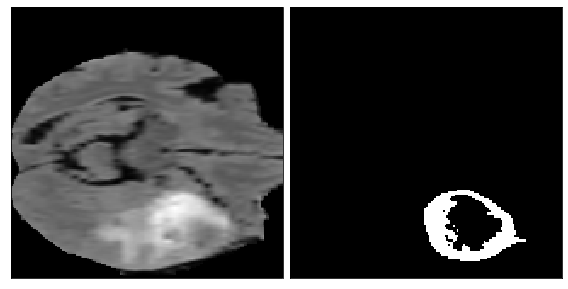

In [21]:
util.visualize_patch(X_norm[0, :, :, :], y[2])

In [22]:
X_norm_with_batch_dimension = np.expand_dims(X_norm, axis=0)
patch_pred = model.predict(X_norm_with_batch_dimension)

In [23]:
# set threshold.
threshold = 0.5

# use threshold to get hard predictions
patch_pred[patch_pred > threshold] = 1.0
patch_pred[patch_pred <= threshold] = 0.0

Now let's visualize the original patch and ground truth alongside our thresholded predictions.

Patch and ground truth


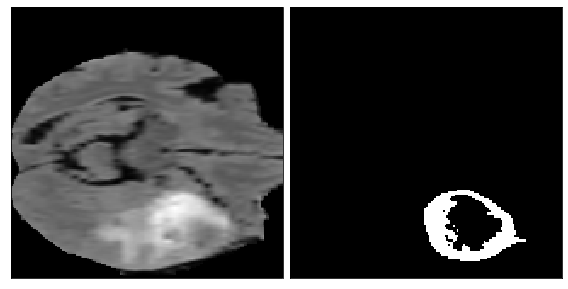

Patch and prediction


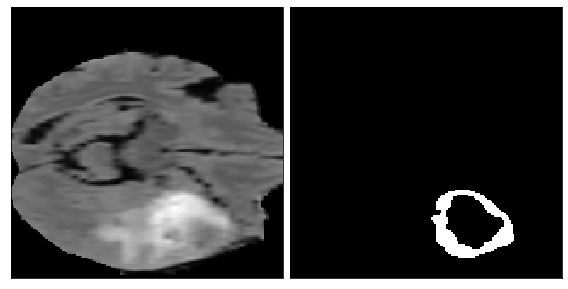

In [24]:
print("Patch and ground truth")
util.visualize_patch(X_norm[0, :, :, :], y[2])
plt.show()
print("Patch and prediction")
util.visualize_patch(X_norm[0, :, :, :], patch_pred[0, 2, :, :, :])
plt.show()

#### 5.2.1 Sensitivity and Specificity

In [27]:
def compute_class_sens_spec(pred, label, class_num):
    """
    Compute sensitivity and specificity for a particular example
    for a given class.

    Args:
        pred (np.array): binary arrary of predictions, shape is
                         (num classes, height, width, depth).
        label (np.array): binary array of labels, shape is
                          (num classes, height, width, depth).
        class_num (int): number between 0 - (num_classes -1) which says
                         which prediction class to compute statistics
                         for.

    Returns:
        sensitivity (float): for a given class_num.
        specificity (float): for a given class_num.
    """

    # extract sub-array for specified class
    class_pred = pred[class_num]
    class_label = label[class_num]

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # compute:
    
    # true positives
    tp = np.sum(np.logical_and(class_pred == 1, class_label == 1))

    # true negatives
    tn = np.sum(np.logical_and(class_pred == 0, class_label == 0))
    
    #false positives
    fp = np.sum(np.logical_and(class_pred == 1, class_label == 0))
    
    # false negatives
    fn = np.sum(np.logical_and(class_pred == 0, class_label == 1))

    # compute sensitivity and specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    ### END CODE HERE ###

    return sensitivity, specificity

#### Sensitivity and Specificity for the patch prediction

Next let's compute the sensitivity and specificity on that patch for expanding tumors. 

In [29]:
sensitivity, specificity = compute_class_sens_spec(patch_pred[0], y, 2)

print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

Sensitivity: 0.7891
Specificity: 0.9960


We can also display the sensitivity and specificity for each class.

In [30]:
def get_sens_spec_df(pred, label):
    patch_metrics = pd.DataFrame(
        columns = ['Edema', 
                   'Non-Enhancing Tumor', 
                   'Enhancing Tumor'], 
        index = ['Sensitivity',
                 'Specificity'])
    
    for i, class_name in enumerate(patch_metrics.columns):
        sens, spec = compute_class_sens_spec(pred, label, i)
        patch_metrics.loc['Sensitivity', class_name] = round(sens,4)
        patch_metrics.loc['Specificity', class_name] = round(spec,4)

    return patch_metrics

In [31]:
df = get_sens_spec_df(patch_pred[0], y)

print(df)

              Edema Non-Enhancing Tumor Enhancing Tumor
Sensitivity  0.9085              0.9505          0.7891
Specificity  0.9848              0.9961           0.996


### 5.3 Running on Entire Scane

In [32]:
# uncomment this code to run it
# image, label = load_case(DATA_DIR + "imagesTr/BRATS_001.nii.gz", DATA_DIR + "labelsTr/BRATS_001.nii.gz")
# pred = util.predict_and_viz(image, label, model, .5, loc=(130, 130, 77))                

Here's a second prediction.
- Takes about 7 to 8 minutes to run

Please run this second prediction so that we can check the predictions.

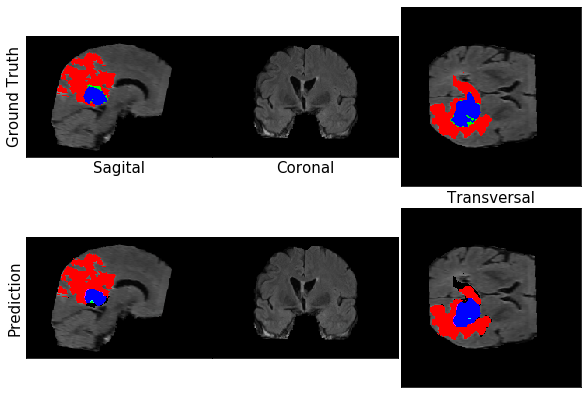

In [33]:
image, label = load_case(DATA_DIR + "imagesTr/BRATS_003.nii.gz", DATA_DIR + "labelsTr/BRATS_003.nii.gz")
pred = util.predict_and_viz(image, label, model, .5, loc=(130, 130, 77))                

In [34]:
whole_scan_label = keras.utils.to_categorical(label, num_classes = 4)
whole_scan_pred = pred

# move axis to match shape expected in functions
whole_scan_label = np.moveaxis(whole_scan_label, 3 ,0)[1:4]
whole_scan_pred = np.moveaxis(whole_scan_pred, 3, 0)[1:4]

Now we can compute sensitivity and specificity for each class just like before.

In [35]:
whole_scan_df = get_sens_spec_df(whole_scan_pred, whole_scan_label)

print(whole_scan_df)

              Edema Non-Enhancing Tumor Enhancing Tumor
Sensitivity   0.902              0.2617          0.8496
Specificity  0.9894              0.9998          0.9982
